In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

In [2]:
import tensorflow as tf 
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
print(device_lib.list_local_devices() )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13436482290737937863
xla_global_id: -1
]


In [5]:
!nvidia-smi

Wed Aug  7 19:06:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.10                 Driver Version: 532.10       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   36C    P8                2W /  N/A|   1039MiB /  8188MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
ROOT_DIR = './Mask_RCNN'

In [3]:
sys.path.append(ROOT_DIR)

In [4]:
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

In [5]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'mask_rcnn_coco.h5')
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [6]:
class TrainConfig(Config):
    
    NAME = 'withme'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 5
    
    LEARNING_RATE = 0.001
    
    NUM_CLASSES = 1 + 34
    
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    BACKBONE = 'resnet50'
    
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 1000

config = TrainConfig()

In [7]:
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                47
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [8]:
class CocoLikeDataset(utils.Dataset):
    def load_data(self, annotation_json, images_dir):
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        source_name = 'coco_like'
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            self.add_class(source_name, class_id, class_name)
            
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                    
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
            
    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

Train 39
Validation 20


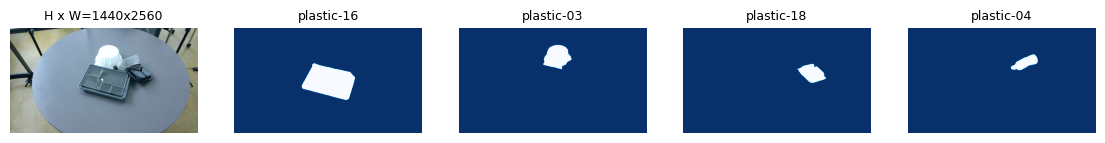

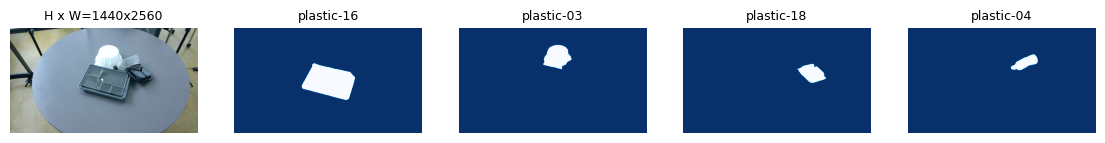

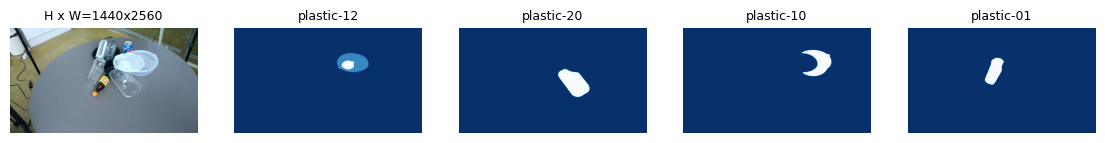

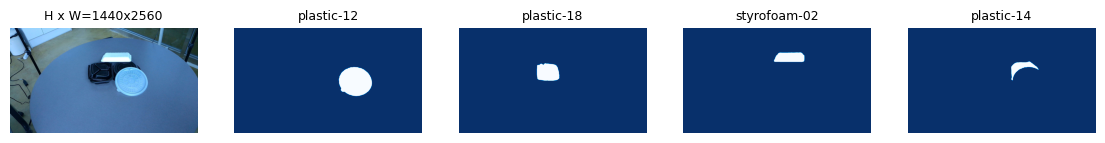

In [9]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('./data_RCNN/train.json', './data_RCNN/train/')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('./data_RCNN/test.json', './data_RCNN/test/')
dataset_val.prepare()

image_ids = np.random.choice(dataset_train.image_ids, 4)

print('Train', len(dataset_train.image_ids))
print('Validation', len(dataset_val.image_ids))

for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [10]:
model = modellib.MaskRCNN(
    mode = 'training',
    config = config,
    model_dir = MODEL_DIR)

model.load_weights(
    COCO_MODEL_PATH,
    by_name = True,
    exclude = ['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [11]:
start_train = time.time()

model.train(
    dataset_train,
    dataset_val, 
    learning_rate=config.LEARNING_RATE, 
    epochs=10, 
    layers='heads')

end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)

print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./Mask_RCNN\logs\withme20240807T1852\mask_rcnn_withme_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDis

KeyboardInterrupt: 

In [12]:
!pip list

Package                      Version
---------------------------- --------------------
absl-py                      1.4.0
addict                       2.4.0
albumentations               1.4.2
anyio                        3.7.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
attrs                        23.1.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
blinker                      1.6.2
cachetools                   5.3.1
certifi                      2023.5.7
cffi                         1.15.1
charset-normalizer           3.1.0
click                        8.1.7
colorama                     0.4.6
coloredlogs                  15.0.1
comm                         0.1.3
contourpy                    1.1.0
cycler                       0.11.0
debugpy                      1.6.7
decorator                   

In [3]:
from torch.utils.data.dataset import Dataset

class WithweDataset(Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
    
    def __len__(self):
        return len(self.imgs)

In [5]:
img = Image.open('./data_RCNN/train/images/10_1.png').convert('RGB')

In [6]:
mask = Image.open('./data_RCNN/train/masks/10_1.png')

In [7]:
mask = np.array(mask)
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [8]:
obj_ids = np.unique(mask)
obj_ids

array([ 0, 11, 14, 19, 20, 21, 22, 23, 24, 25, 30], dtype=uint8)

In [9]:
obj_ids = obj_ids[1:]
obj_ids

array([11, 14, 19, 20, 21, 22, 23, 24, 25, 30], dtype=uint8)

In [11]:
masks = mask == obj_ids[:, None, None]
masks

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [12]:
masks.shape

(10, 1440, 2560)

In [13]:
num_objs = len(obj_ids)
boxes = []
for i in range(num_objs):
    pos = np.nonzero(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])

In [14]:
boxes

[[1083, 444, 1297, 755],
 [1114, 842, 1547, 1097],
 [1500, 691, 1702, 885],
 [1215, 275, 1606, 604],
 [1264, 786, 1426, 886],
 [1387, 312, 1798, 580],
 [1320, 627, 1484, 762],
 [1400, 618, 1900, 979],
 [1427, 668, 1760, 906],
 [1567, 500, 1907, 726]]

In [15]:
boxes = torch.as_tensor(boxes, dtype=torch.float32)
boxes.shape

torch.Size([10, 4])

In [16]:
labels = torch.as_tensor(obj_ids, dtype=torch.int64)
labels

tensor([11, 14, 19, 20, 21, 22, 23, 24, 25, 30])

In [17]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

num_classes = 35

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\Lenovo/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|███████████████████████████████████████████████████████████████████████████████| 160M/160M [00:18<00:00, 9.25MB/s]
